# DataJoint U24 Workflow Ephys
This notebook will describe the steps for interacting with the data ingested into `workflow-ephys`.

Prior to using this notebook, please refer to the [README](https://github.com/datajoint/workflow-ephys) for the topics listed below.
    + Installation instructions
    + Directory structure and file naming convention
    + Running the workflow


In [1]:
import os
os.chdir('..')

In [2]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_ephys.pipeline import *

Connecting root@localhost:3306


## Workflow architecture

This workflow is assembled from 3 DataJoint elements:
+ [elements-lab](https://github.com/datajoint/elements-lab)
+ [elements-animal](https://github.com/datajoint/elements-animal)
+ [elements-ephys](https://github.com/datajoint/elements-ephys)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


In [3]:
erd = dj.Diagram(ephys) + (dj.Diagram(Session) + 1) - 1

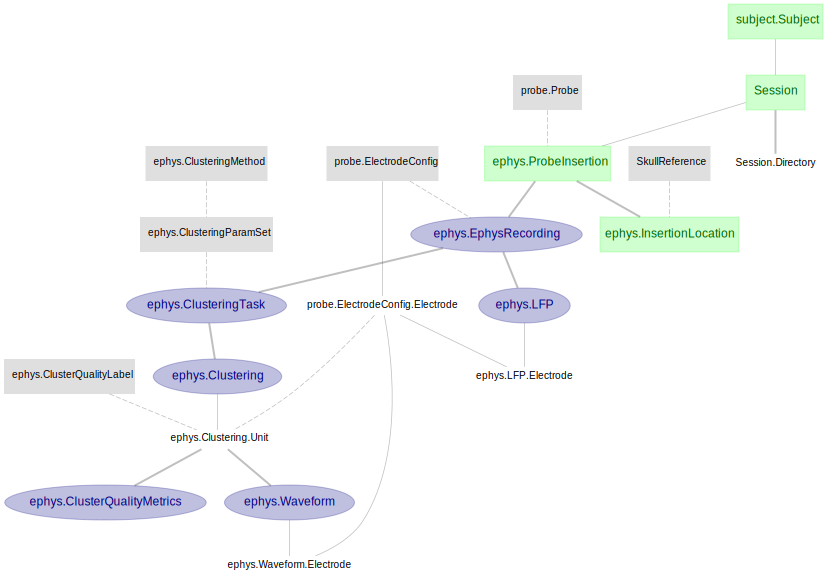

In [4]:
erd

## Browsing the data

As users, follow through the instructions, you've interacted with this workflow by:

1. Created and added new `ClusteringParamSet` - first step in [run_workflow.ipynb notebook](./run_workflow.ipynb)
2. Added new subjects and sessions in ***subject.csv*** and ***sessions.csv*** files, and executed the ***ingest.py*** script
3. Run the populate routine in the ***populate.py*** script

#### Step 1 creates and adds entries into the `ephys.ClusteringParamSet` table

In [5]:
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


In [6]:
paramset_0 = (ephys.ClusteringParamSet & 'paramset_idx=0').fetch1('params')

In [7]:
paramset_0

{'fs': 30000,
 'fshigh': 150,
 'minfr_goodchannels': 0.1,
 'Th': [10, 4],
 'lam': 10,
 'AUCsplit': 0.9,
 'minFR': 0.02,
 'momentum': [20, 400],
 'sigmaMask': 30,
 'ThPr': 8,
 'spkTh': -6,
 'reorder': 1,
 'nskip': 25,
 'GPU': 1,
 'Nfilt': 1024,
 'nfilt_factor': 4,
 'ntbuff': 64,
 'whiteningRange': 32,
 'nSkipCov': 25,
 'scaleproc': 200,
 'nPCs': 3,
 'useRAM': 0}

#### Step 2 loads the `.csv` files and inserts into ***Subject*** and ***Session*** tables

In [8]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject1,F,2019-01-01,no description
subject2,M,2020-01-01,no description
subject3,M,2021-01-01,no description


In [9]:
Session()

subject,session_datetime
subject1,2018-11-22 18:51:26
subject2,2020-01-07 11:17:23
subject2,2020-01-10 14:28:08
subject3,2019-11-19 11:51:24


#### Step 3 processes the data through the pipeline, populating downstream tables in the `elements-ephys`

For each added session, session data are imported, processed, and inserted into tables in the `probe` and `ephys` schemas such as:
+ probe.ElectrodeConfig
+ ephys.ProbeInsertion
+ ephys.EphysRecording
+ ephys.Clustering
+ ephys.Waveform

Let's pick one session and follow its data throughout the pipeline

In [10]:
session_key = (Session & 'subject="subject2"' & 'session_datetime = "2020-01-07 11:17:23"').fetch1('KEY')

In [11]:
session_key

{'subject': 'subject2',
 'session_datetime': datetime.datetime(2020, 1, 7, 11, 17, 23)}

##### `ephys.ProbeInsertion` and `ephys.EphysRecording` stores the number of probes and the probe recordings from a particular session

In [12]:
ephys.ProbeInsertion & session_key

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. part number)
subject2,2020-01-07 11:17:23,0,19011116163
subject2,2020-01-07 11:17:23,1,19011111614
subject2,2020-01-07 11:17:23,2,19011111142


(note that this session has 3 probes)

In [13]:
ephys.EphysRecording & session_key

subject,session_datetime,insertion_number,electrode_config_hash,sampling_rate (Hz)
subject2,2020-01-07 11:17:23,0,d8fb7e4f-131c-1d67-50eb-124430ad2859,29999.5
subject2,2020-01-07 11:17:23,1,fefd1aa0-3001-c5cc-4297-1edd60395c41,29999.4
subject2,2020-01-07 11:17:23,2,d8fb7e4f-131c-1d67-50eb-124430ad2859,29999.7


##### Spike-sorting is performed on a per-probe basis
The details are stored in `ephys.ClusteringTask` and `ephys.Clustering`

In [14]:
ephys.ClusteringTask * ephys.Clustering & session_key

subject,session_datetime,insertion_number,paramset_idx,clustering_time time of generation of this set of clustering results,quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,clustering_note
subject2,2020-01-07 11:17:23,0,0,2021-01-27 17:40:31,1,0,
subject2,2020-01-07 11:17:23,1,0,2021-01-27 17:42:58,1,0,
subject2,2020-01-07 11:17:23,2,0,2021-01-27 17:45:43,1,0,


##### Spike-sorting results are stored in `ephys.Clustering`, `ephys.Waveform`

In [15]:
ephys.Clustering.Unit & session_key

subject,session_datetime,insertion_number,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 1",cluster_quality_label,spike_count how many spikes in this recording of this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject2,2020-01-07 11:17:23,0,0,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,5,good,10554,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,1,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,5,mua,9373,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,2,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,9,good,9991,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,3,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,11,good,3667,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,4,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,13,good,27271,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,5,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,17,good,1377,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,6,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,17,mua,78,=BLOB=,=BLOB=,=BLOB=


## Query/Fetch the data

##### Let's pick one probe and further inspect the clustering results

In [16]:
insertion_key = (ephys.Clustering & session_key & 'insertion_number = 0').fetch1('KEY')

In [17]:
ephys.Clustering.Unit & insertion_key

subject,session_datetime,insertion_number,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 1",cluster_quality_label,spike_count how many spikes in this recording of this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject2,2020-01-07 11:17:23,0,0,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,5,good,10554,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,1,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,5,mua,9373,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,2,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,9,good,9991,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,3,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,11,good,3667,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,4,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,13,good,27271,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,5,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,17,good,1377,=BLOB=,=BLOB=,=BLOB=
subject2,2020-01-07 11:17:23,0,6,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,17,mua,78,=BLOB=,=BLOB=,=BLOB=


##### Let's try a raster plot - just the "good" units

In [18]:
units, unit_spiketimes = (ephys.Clustering.Unit & insertion_key & 'cluster_quality_label = "good"').fetch('unit', 'spike_times')

In [19]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])

Text(0, 0.5, 'Unit')

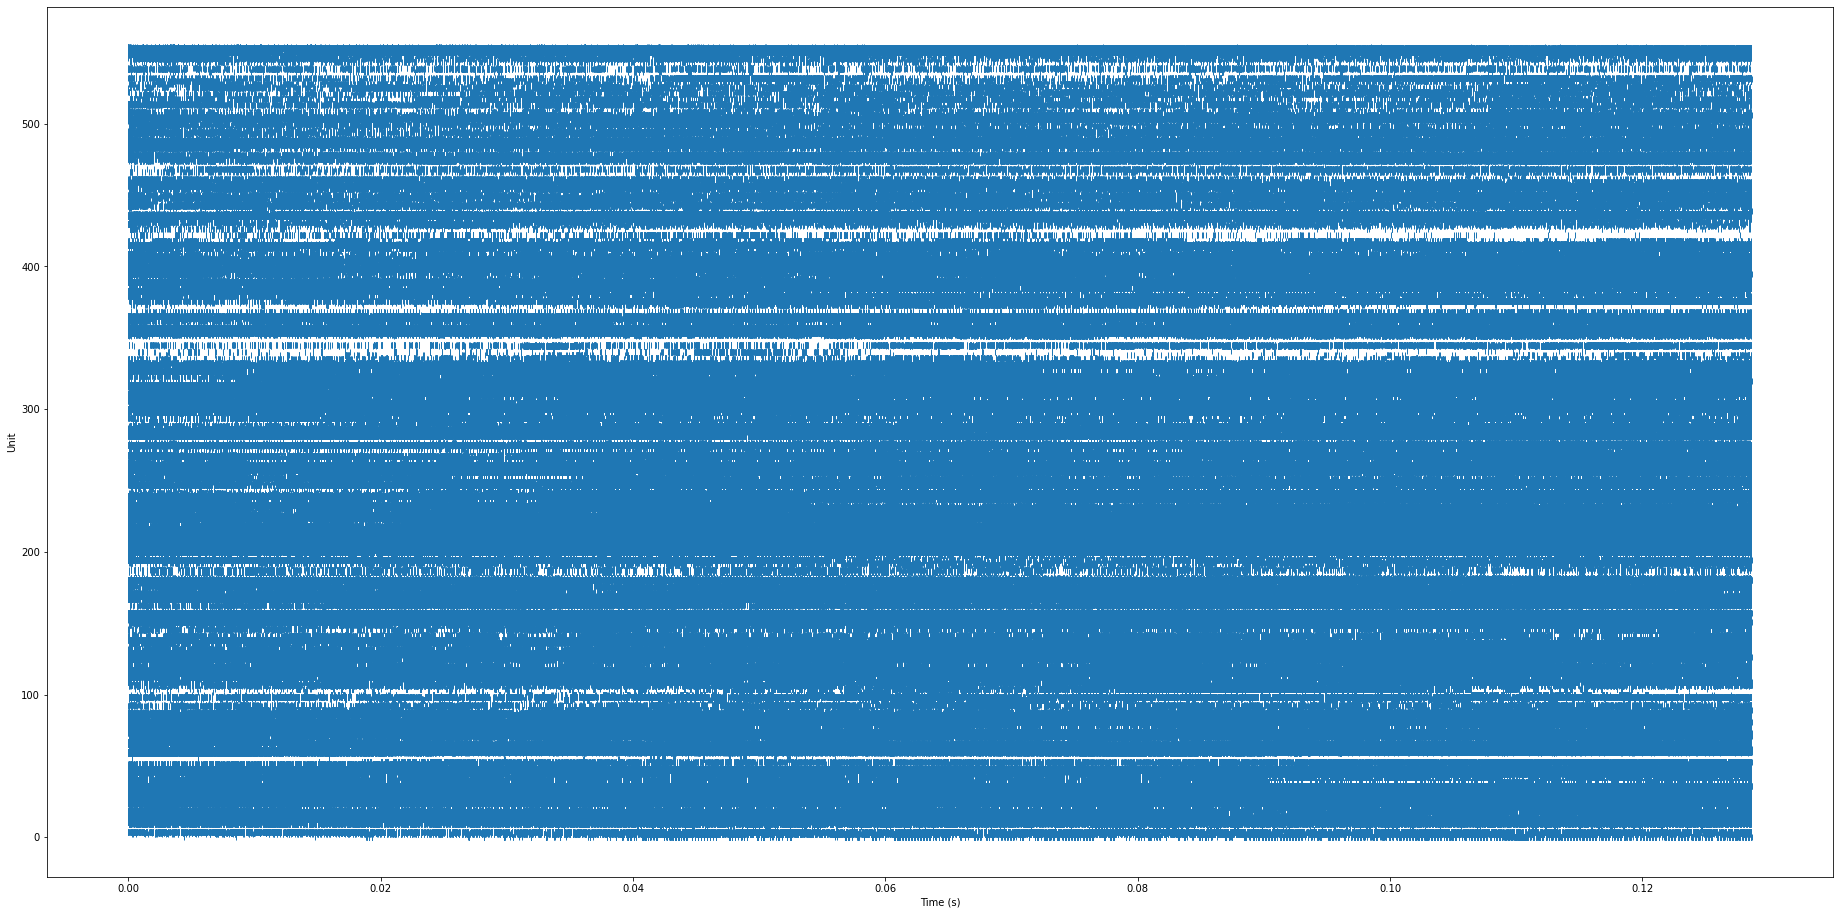

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(32, 16))
ax.plot(x, y, '|')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Unit')

##### Let's pick one unit and futher inspect

In [21]:
unit_key = (ephys.Clustering.Unit & session_key & 'insertion_number = 0' & 'unit = 11').fetch1('KEY')

In [22]:
ephys.Clustering.Unit * ephys.Waveform & unit_key

subject,session_datetime,insertion_number,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 1",cluster_quality_label,spike_count how many spikes in this recording of this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe",peak_chn_waveform_mean mean over all spikes at the peak channel for this unit
subject2,2020-01-07 11:17:23,0,11,d8fb7e4f-131c-1d67-50eb-124430ad2859,neuropixels 2.0 - MS,30,good,50101,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [23]:
unit_data = (ephys.Clustering.Unit * ephys.Waveform & unit_key).fetch1()

In [24]:
unit_data

{'subject': 'subject2',
 'session_datetime': datetime.datetime(2020, 1, 7, 11, 17, 23),
 'insertion_number': 0,
 'unit': 11,
 'electrode_config_hash': UUID('d8fb7e4f-131c-1d67-50eb-124430ad2859'),
 'probe_type': 'neuropixels 2.0 - MS',
 'electrode': 30,
 'cluster_quality_label': 'good',
 'spike_count': 50101,
 'spike_times': array([2.68904676e-07, 2.76898148e-06, 4.01346979e-06, ...,
        1.28649440e-01, 1.28653484e-01, 1.28655449e-01]),
 'spike_sites': array([30, 30, 30, ..., 30, 30, 30]),
 'spike_depths': array([223.05524123, 215.92988026, 221.65602926, ..., 243.81972498,
        249.03015073, 242.37791498]),
 'peak_chn_waveform_mean': array([ 0.00000000e+00,  2.82287598e-02,  6.79779053e-01,  1.03454590e+00,
         7.32421875e-01,  4.92858887e-01,  6.10351562e-01,  5.25665283e-01,
         3.90625000e-01, -9.15527344e-03, -4.47845459e-01, -5.27954102e-01,
        -1.06506348e+00, -2.65884399e+00, -5.98907471e+00, -1.12861633e+01,
        -1.68777466e+01, -2.07679749e+01, -2.220

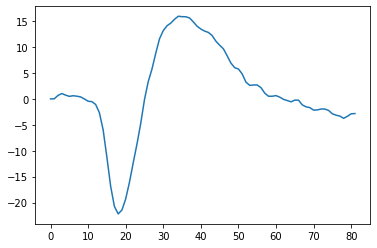

In [25]:
plt.plot(unit_data['peak_chn_waveform_mean'])